# 3D model selection!!

Report the validation-set ELBO at every epoch, and pick the best. Do this for the reference and target models.



In [1]:
import json
from integrated_cell import model_utils, utils
import os
import numpy as np
from natsort import natsorted
import glob
import pickle
from tqdm import tqdm

import torch

from integrated_cell.metrics.embeddings_target import get_latent_embeddings as get_latent_embeddings_target
from integrated_cell.metrics.embeddings_reference import get_latent_embeddings as get_latent_embeddings_ref


import pickle

class RenamingUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'integrated_cell.SimpleLogger':
            module = 'integrated_cell.simplelogger'
        return super().find_class(module, name)

def get_embeddings_for_model(suffix, model_dir, parent_dir, save_path, use_current_results):

    if not os.path.exists(save_path):  # CC
        if use_current_results:
            return None
            
        networks, dp, args = utils.load_network_from_dir(model_dir, parent_dir, suffix = suffix)  # CC

        recon_loss = utils.load_losses(args)['crit_recon']

        enc = networks['enc']
        dec = networks['dec']

        enc.train(False)
        dec.train(False)

        if model == "ref":
            embeddings = get_latent_embeddings_ref(enc, dec, dp, modes=["validate"], recon_loss = recon_loss, batch_size = 32)  # CC
        elif model == "target":
            embeddings = get_latent_embeddings_target(enc, dec, dp, modes=["validate"], recon_loss = recon_loss, batch_size = 32)  # CC
        else:
            pass

        torch.save(embeddings, save_path)  # CC
    else:
        embeddings = torch.load(save_path)

    return embeddings


def embeddings2elbo(embeddings):

    recon_per_point = torch.mean(embeddings['validate'][model]['recon'], 1)
    kld_per_point =  embeddings['validate'][model]['kld']
    
    elbo_per_point = -(recon_per_point + kld_per_point)
    
    return elbo_per_point, recon_per_point, kld_per_point


def get_embeddings_for_dir(model_dir, parent_dir, use_current_results=False):
    model_paths = np.array(natsorted(glob.glob('{}/ref_model/enc_*'.format(model_dir))))
    
    #evenly sample 25 points along the training path
    inds = np.linspace(0, len(model_paths)-1, 25).astype('int')
    
    model_paths = model_paths[inds]
    
    suffixes = [model_path.split('/enc')[1].split('.pth')[0] for model_path in model_paths]
    
    results_dir = '{}/results'.format(model_dir)  # CC
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    embeddings_list = list()
    
    logger_file = '{0}/ref_model/logger_tmp.pkl'.format(model_dir)  # CC
    
    if not os.path.exists(logger_file):
        return
    
    with open( logger_file, "rb" ) as fp:
        logger = RenamingUnpickler(fp).load()

    args_file = "{}/args.json".format(model_dir)  # CC
    with open(args_file, "r") as f:
        args = json.load(f)
    
    model_summaries = list()
    
    for suffix in suffixes:
        
        model_summary_path = "{}/ref_model/embeddings_validate{}_summary.pth".format(model_dir, suffix)  # CC
        
        if os.path.exists(model_summary_path):
            with open(model_summary_path, "rb") as f:
                model_summary = pickle.load(f)
        else:
            embeddings_path = "{}/ref_model/embeddings_validate{}.pth".format(model_dir, suffix)  # CC

            embeddings = get_embeddings_for_model(suffix, model_dir, parent_dir, embeddings_path, use_current_results)  # CC

            if embeddings is None: continue

            opt = json.load(open( '{0}/args.json'.format(model_dir), "rb" ))  # CC

            iteration = int(suffix[1:])-1
            iteration_index = np.where(np.array(logger.log['iter']) == iteration)[0]

            if len(iteration_index) == 0:
                continue

            if 'beta' in opt['kwargs_model']:
                embeddings['beta'] = opt['kwargs_model']['beta']
            else:
                embeddings['beta'] = 1

            embeddings['elbo'], embeddings['recon'], embeddings['kld'] = embeddings2elbo(embeddings)

            model_summary = {"iteration": iteration,
                    "epoch": np.array(logger.log['epoch'])[iteration_index],
                    "elbo": np.mean(embeddings['elbo'].numpy()),
                    "recons": np.mean(embeddings['recon'].numpy()),
                    "klds": np.mean(embeddings['kld'].numpy()),
                    "model_dir": model_dir,
                    "label": model_dir.split('/')[-2],
                    "suffix": suffix,
                    "args": args}

            with open(model_summary_path, "wb") as f:
                pickle.dump(model_summary, f)

        model_summaries.append(model_summary)
            
    return model_summaries


gpu_ids = [7]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])
if len(gpu_ids) == 1:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True




#parent_dir = "/allen/aics/modeling/gregj/results/integrated_cell/"  # CC
parent_dir = "/allen/aics/modeling/ic_data/results/integrated_cell/"  # CC

model_parent = '{}/test_cbvae_avg_inten'.format(parent_dir)  # CC

#target dirs
#model_dirs = ["/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/",
#             "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-31-21:48:56/",
#             ]  # CC
model_dirs = ["/allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/",
             "/allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-31-21:48:56/",
             ]  # CC
model = "target"


#reference dirs
#model_dirs = ["/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04",
#              "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:23:27",
#             ]  # CC
model_dirs = ["/allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04",
              "/allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:23:27",
             ]  # CC
model = "ref"

data_list = list()
for i, model_dir in enumerate(model_dirs):
    print(model_dir)
    

    model_summaries = get_embeddings_for_dir(model_dir, parent_dir, use_current_results = False)  # CC

    if model_summaries is None:
        continue
    
    iteration = np.array([model_summary['iteration'] for model_summary in model_summaries])
    epoch = np.array([model_summary['epoch'] for model_summary in model_summaries])
    elbo = np.array([model_summary['elbo'] for model_summary in model_summaries])
    recons = np.array([model_summary['recons'] for model_summary in model_summaries])
    klds = np.array([model_summary['klds'] for model_summary in model_summaries])
    args = [model_summary['args'] for model_summary in model_summaries]
    suffix = [model_summary['suffix'] for model_summary in model_summaries]
    
    if len(elbo) == 0:
        continue
        
    if 'beta' in args[0]['kwargs_model']:
        beta = args[0]['kwargs_model']['beta']
    else:
        beta = 1
        
#     beta = args[0]['kwargs_model']['beta']
        
    max_ind = np.argmax( - (recons + beta*klds))
    epoch_num = epoch[max_ind]
    
    best_ind = int(max_ind)
    best_elbo = elbo[max_ind]
    
    label = model_dir.split('/')[-2]
    
    model_summary = {"iteration": iteration,
                    "epoch": epoch,
                    "elbo": elbo,
                    "recons": recons,
                    "klds": klds,
                    "model_dir": model_dir,
                    "label": label,
                    "suffix": suffix,
                    "args": args,
                    "best_ind": best_ind,
                    "best_elbo": best_elbo,
                    "beta": beta}
    

    data_list.append(model_summary)
        
        
save_dir = '{}/results'.format(model_parent)  # CC

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

/allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04
/allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:23:27


In [2]:
# INCEPTION SCORES

import tqdm 
import matplotlib
import torch

from skimage.external.tifffile import imsave

#Sample a generated and real images into their own class folders
modes = ['train','test','validate']

im_paths_real = {}
im_scores_real = {}
im_paths_gen = {}

class_list = list()
path_list = list()
mode_list = list()

_, dp, _ = utils.load_network_from_dir(data_list[0]['model_dir'], parent_dir)  # CC
#dp.image_parent = '/allen/aics/modeling/gregj/results/ipp/scp_19_04_10/'  # CC
dp.image_parent = '/allen/aics/modeling/ic_data/results/ipp/scp_19_04_10/'  # CC

# ######
# ### Now the generated stuff
# ######

class_list = np.array(class_list)
path_list = np.array(path_list)
mode_list = np.array(mode_list)

class_list_gen = class_list[mode_list == 'validate']

im_paths_gen = {}
im_scores_gen = {}

#sample n_train images and stick them into directories
for i, data in enumerate(data_list):    

    model_ind = int(data['best_ind'])
    
    if len(data['suffix']) == 0:
        continue
        
    #Make sure we get the hightest-ELBO model
        
    suffix = data['suffix'][model_ind]
    model_dir = data['model_dir']
    model_short = data['model_dir'].split('/')[-2]

    im_paths_gen[i] = {}
    im_scores_gen[i] = {}
    
    im_scores_gen[i]['model_dir'] = data['model_dir']
    im_scores_gen[i]['label'] = data['label']
    im_scores_gen[i]['suffix'] = data['suffix'][model_ind]    
    im_scores_gen[i]['elbo'] = data['elbo'][model_ind]
    im_scores_gen[i]['recon'] = data['recons'][model_ind]
    im_scores_gen[i]['kld'] = data['klds'][model_ind]
    im_scores_gen[i]['epoch'] = data['epoch'][model_ind]
    im_scores_gen[i]['im_path'] = '{}/ref_model/progress_{}.png'.format(model_dir, int(data['elbo'][model_ind]))
    im_scores_gen[i]['args'] = data['args'][model_ind]
    im_scores_gen[i]['beta'] = data['beta']
    
  

args file exists and overwrite is not set to True. Using existing args file.
args file exists and overwrite is not set to True. Using existing args file.


loading from /allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/enc.pth
loading from /allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/dec.pth


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [3]:
import pandas as pd

for i in im_scores_gen:
    #log specific model architechure choices
    
    color = 'k'
    im_scores_gen[i]['noise_enc'] = 0
    if ('noise_std' in im_scores_gen[i]['args']['kwargs_enc']) and (im_scores_gen[i]['args']['kwargs_enc']['noise_std'] > 0):
        noise_std = im_scores_gen[i]['args']['kwargs_enc']['noise_std']
        
        im_scores_gen[i]['noise_enc'] = noise_std
        
        color = 'g'
        if noise_std == 0.2:
            color = 'r'

    marker = '^'
    
    if 'proj' in im_scores_gen[i]['args']['network_name']:
        im_scores_gen[i]['ref_proj'] = 0
    else:
        im_scores_gen[i]['ref_proj'] = 1
        marker = 's'
    
    if 'resid' in im_scores_gen[i]['args']['network_name']:
        im_scores_gen[i]['resid'] = 0
    else:
        im_scores_gen[i]['resid'] = 1
        marker = 'p'
        
    if ('proj_z' in im_scores_gen[i]['args']['kwargs_dec']) and im_scores_gen[i]['args']['kwargs_dec']['proj_z']:
        im_scores_gen[i]['z_skip'] = 1
        marker = 'h'
    else:
        im_scores_gen[i]['z_skip'] = 0

    if ('proj_z_ref_to_target' in im_scores_gen[i]['args']['kwargs_dec']) and im_scores_gen[i]['args']['kwargs_dec']['proj_z_ref_to_target']:
        im_scores_gen[i]['z_skip_to_target'] = 1
        marker = '*'
    else:
        im_scores_gen[i]['z_skip_to_target'] = 0
        
    if im_scores_gen[i]['args']['model_type'] == 'ae':
        im_scores_gen[i]['gan'] = 0
    else:
        im_scores_gen[i]['gan'] = 1
        marker = '$G$'
        
    if "masked_channels" in im_scores_gen[i]['args']['kwargs_dp']:
        im_scores_gen[i]['masked_channels'] = im_scores_gen[i]['args']['kwargs_dp']['masked_channels']
    else:
        im_scores_gen[i]['masked_channels'] = -1

#     im_scores_gen[i]['beta'] = im_scores_gen[i]['args']['kwargs_model']['beta']
    im_scores_gen[i]['marker'] = marker
    im_scores_gen[i]['color'] = color



for i in im_scores_gen:
    im_scores_gen[i]['model_arch_str'] = 'resid:{}, ref proj:{}, z-self:{}, z-target:{}, GAN:{}, noise:{}, beta:{}'.format(
        im_scores_gen[i]['resid'],
        im_scores_gen[i]['ref_proj'],
        im_scores_gen[i]['z_skip'],
        im_scores_gen[i]['z_skip_to_target'],
        im_scores_gen[i]['gan'],
        im_scores_gen[i]['noise_enc'],
        im_scores_gen[i]['beta']
    )
    
df_master = pd.DataFrame.from_dict([im_scores_gen[i] for i in im_scores_gen])    

for s in df_master['model_arch_str']: print(s)

resid:1, ref proj:1, z-self:0, z-target:0, GAN:0, noise:0, beta:1
resid:1, ref proj:1, z-self:0, z-target:0, GAN:0, noise:0, beta:1


Text(-0.15,1.05,'a)')

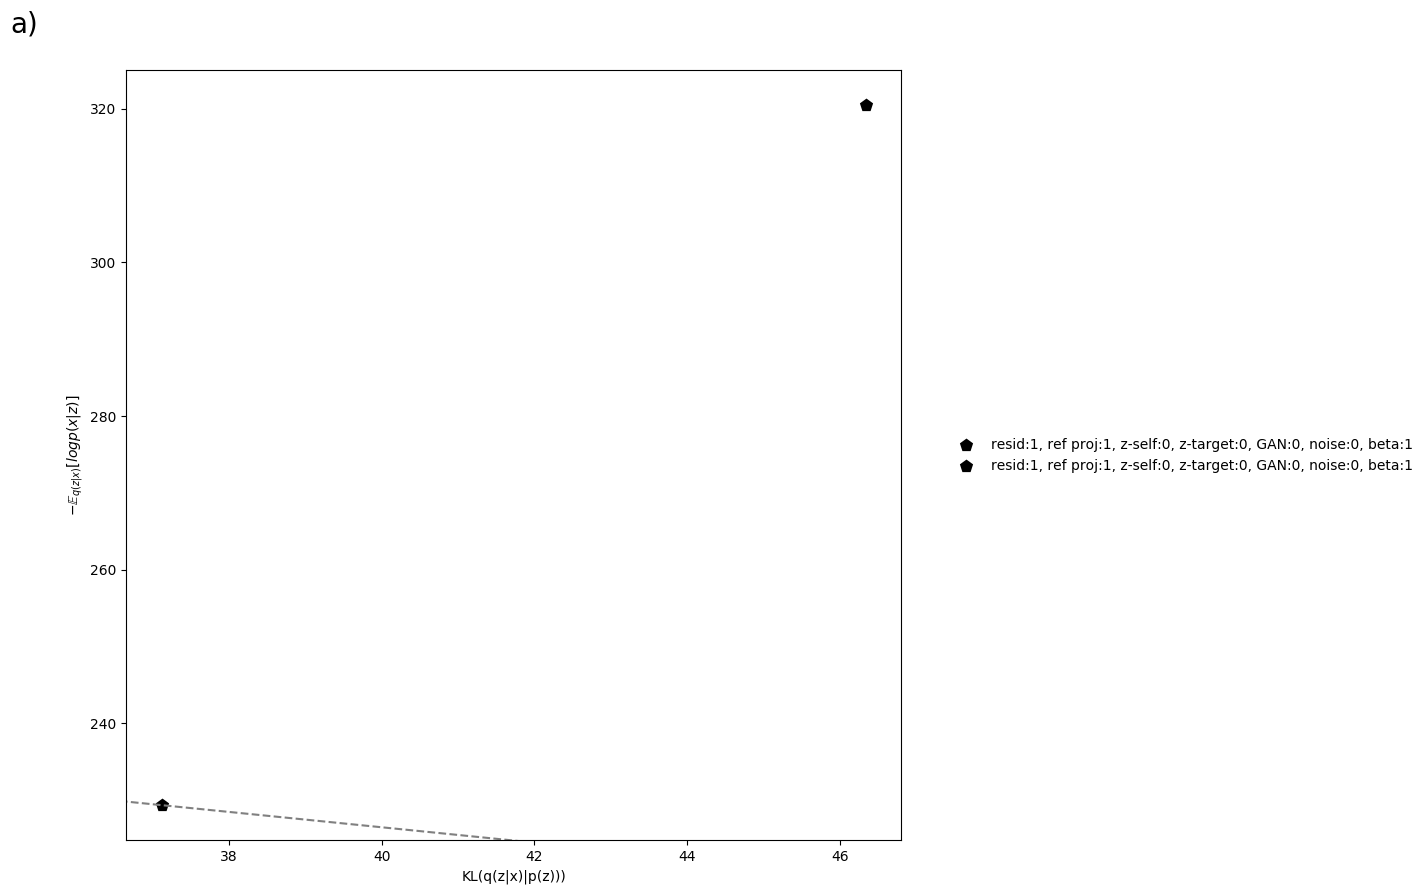

In [4]:

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('default')

letter_x = -0.15
letter_y = 1.05

df = df_master[(df_master['beta'] == 1) & (df_master['masked_channels'] == -1)]

# markers = ['^', 's', 'p', 'h', '*', '$G$']*2
# colors = [[0, 0, 0]]*6 + [[1, 0, 0]]*6

plt.figure(figsize=[10,10])
# plt.subplot(2,2,1)

for i, [r, d, label, marker, color, beta] in enumerate(zip(df['kld'], df['recon'], df['model_arch_str'], df['marker'], df['color'], df['beta'])):
    
    plt.scatter(r, d, label=label, marker = marker, color = color, linewidth=0, s = 100)
    
xlim = plt.xlim()
ylim = plt.ylim()    
    
elbo = np.min(-df['elbo'])
plt.plot([0, elbo], [elbo, 0], '--', c='gray')

plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel('KL(q(z|x)|p(z)))')
plt.ylabel(r'$- \mathbb{E}_{q(z|x)}[logp(x|z)]$')    
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1, frameon=False)

plt.gca().text(letter_x, letter_y, 'a)', transform=plt.gca().transAxes, size=20)


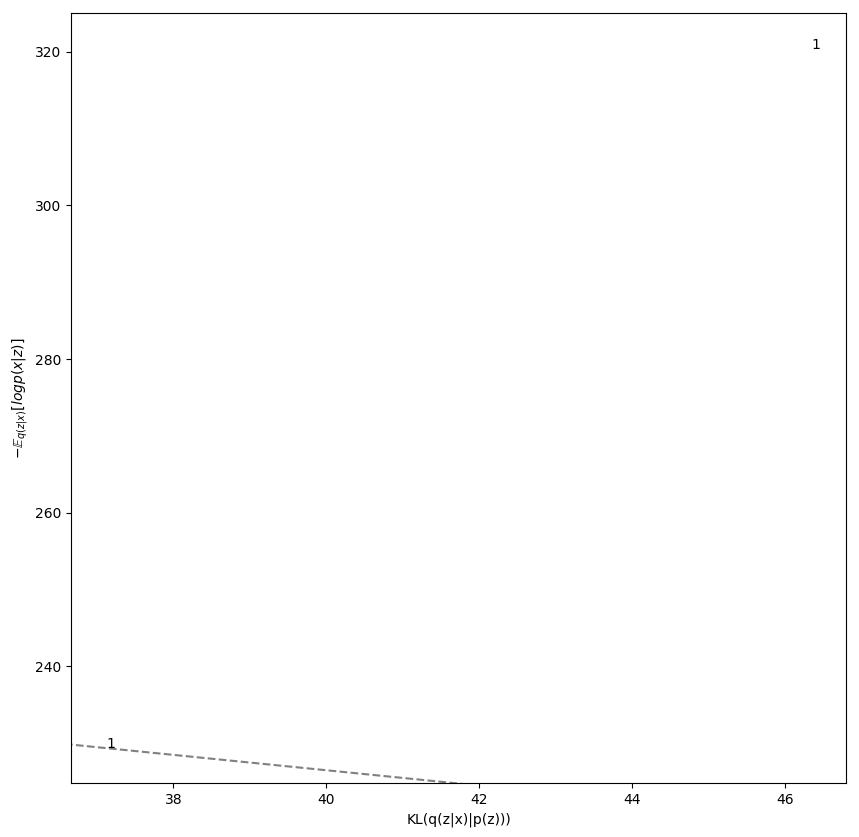

In [5]:

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('default')

letter_x = -0.15
letter_y = 1.05

df = df_master[(df_master['resid'] == 1) & (df_master['masked_channels'] == -1) & (df_master['ref_proj'] == 1) & (df_master['z_skip'] == 0) & (df_master['z_skip_to_target'] == 0)]

# markers = ['^', 's', 'p', 'h', '*', '$G$']*2
# colors = [[0, 0, 0]]*6 + [[1, 0, 0]]*6

plt.figure(figsize=[10,10])

for i, [r, d, label, marker, color, beta] in enumerate(zip(df['kld'], df['recon'], df['model_arch_str'], df['marker'], df['color'], df['beta'])):
    
    plt.scatter(r, d, label=label, marker = '$'+str(beta)+'$', color = 'w', linewidth=0, s = 100)
    plt.text(r, d, str(beta))
    
xlim = plt.xlim()
ylim = plt.ylim()    
    
elbo = np.min(-df['elbo'])
plt.plot([0, elbo], [elbo, 0], '--', c='gray')

plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel('KL(q(z|x)|p(z)))')
plt.ylabel(r'$- \mathbb{E}_{q(z|x)}[logp(x|z)]$')    
# plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1, frameon=False)

# plt.gca().text(letter_x, letter_y, 'a)', transform=plt.gca().transAxes, size=20)

plt.savefig('{}/model_selection_beta.png'.format(save_dir), bbox_inches='tight', dpi=90)  # CC

plt.show()

In [6]:
for d in data_list: print(d['label'])

test_cbvae_3D_avg_inten
test_cbvae_3D_avg_inten


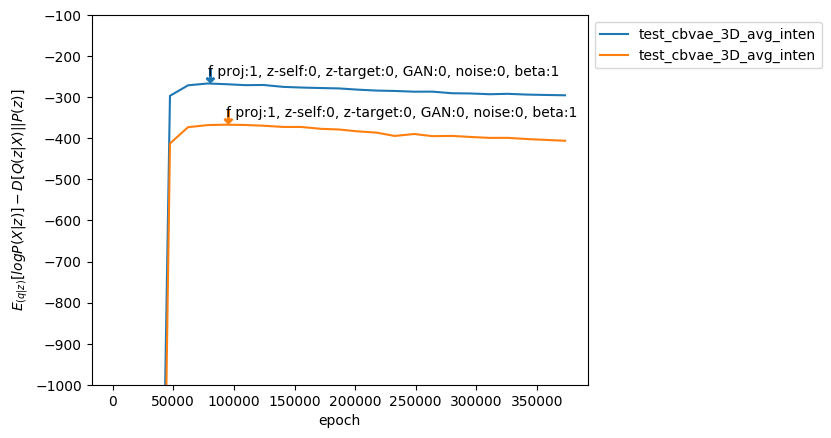

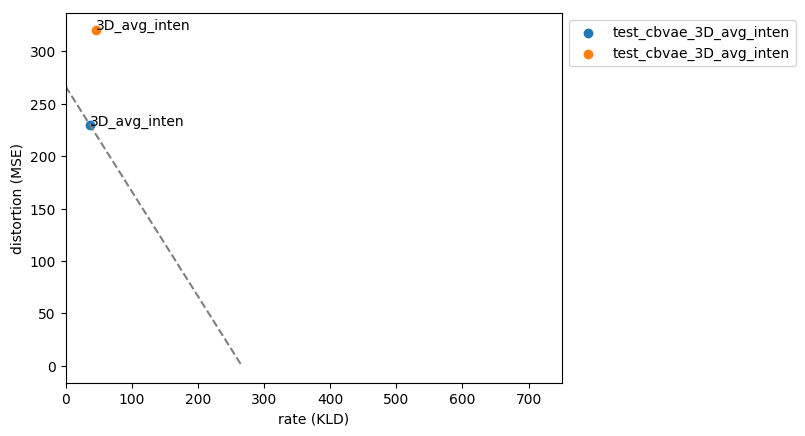

/allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04


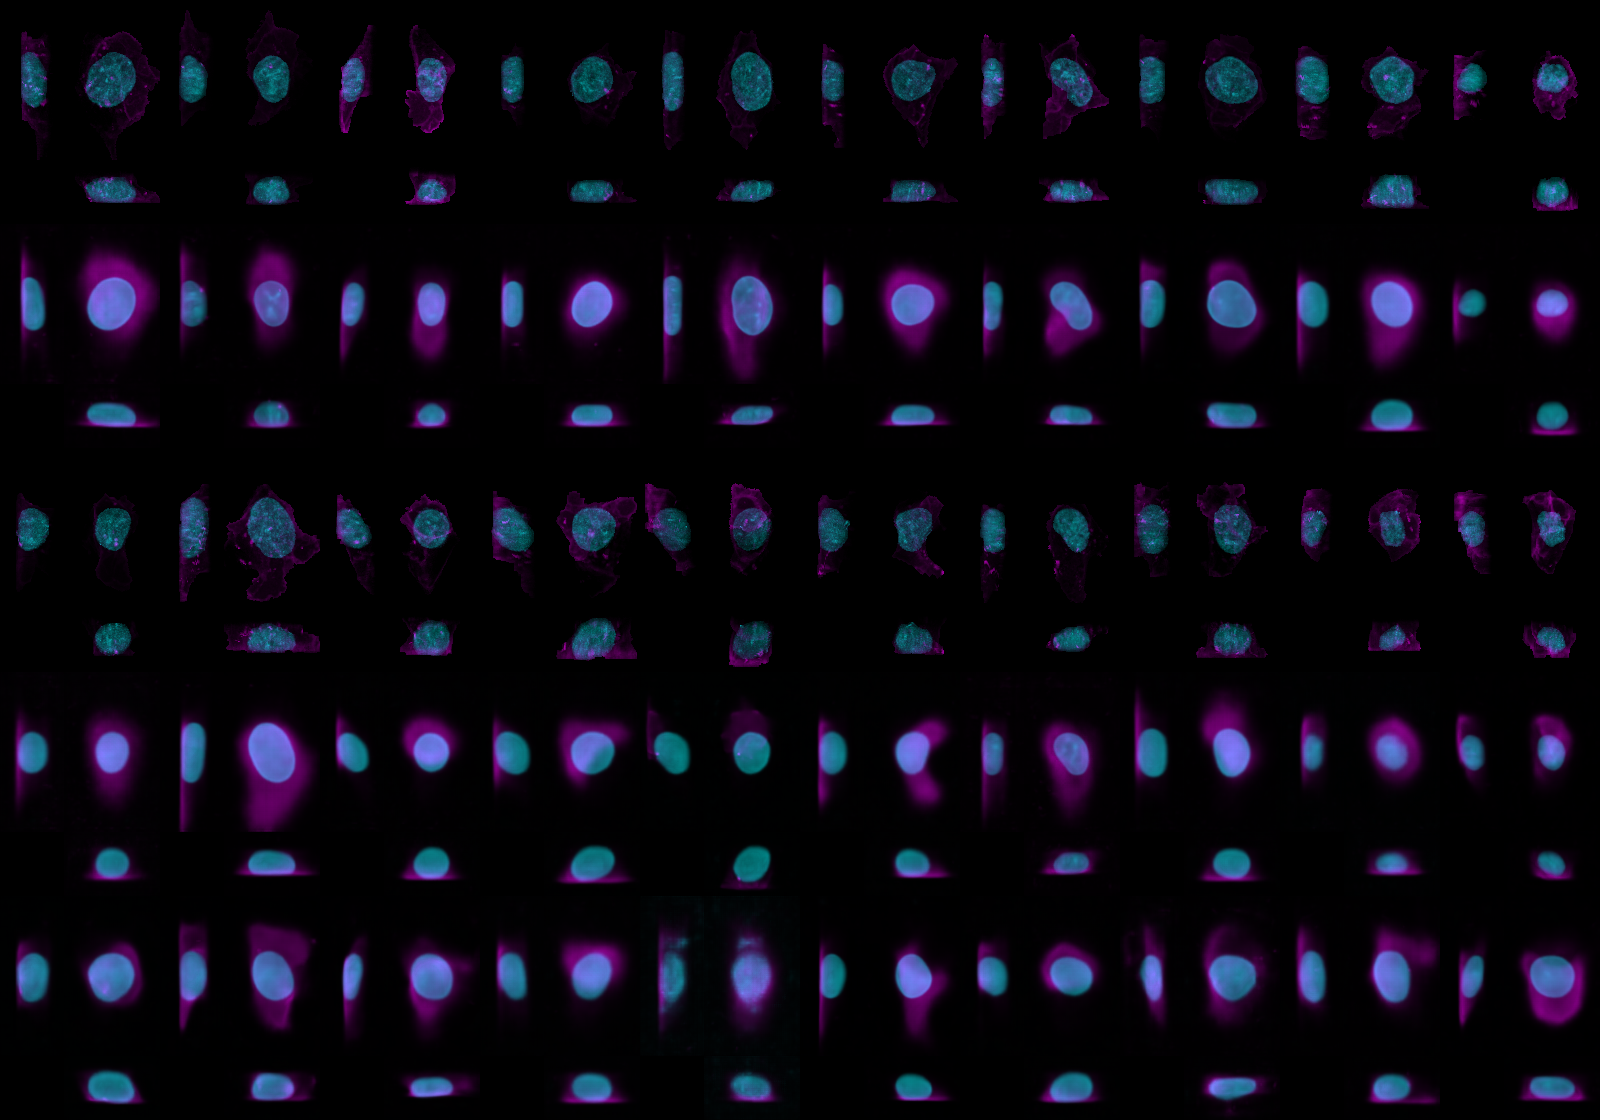

/allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:23:27


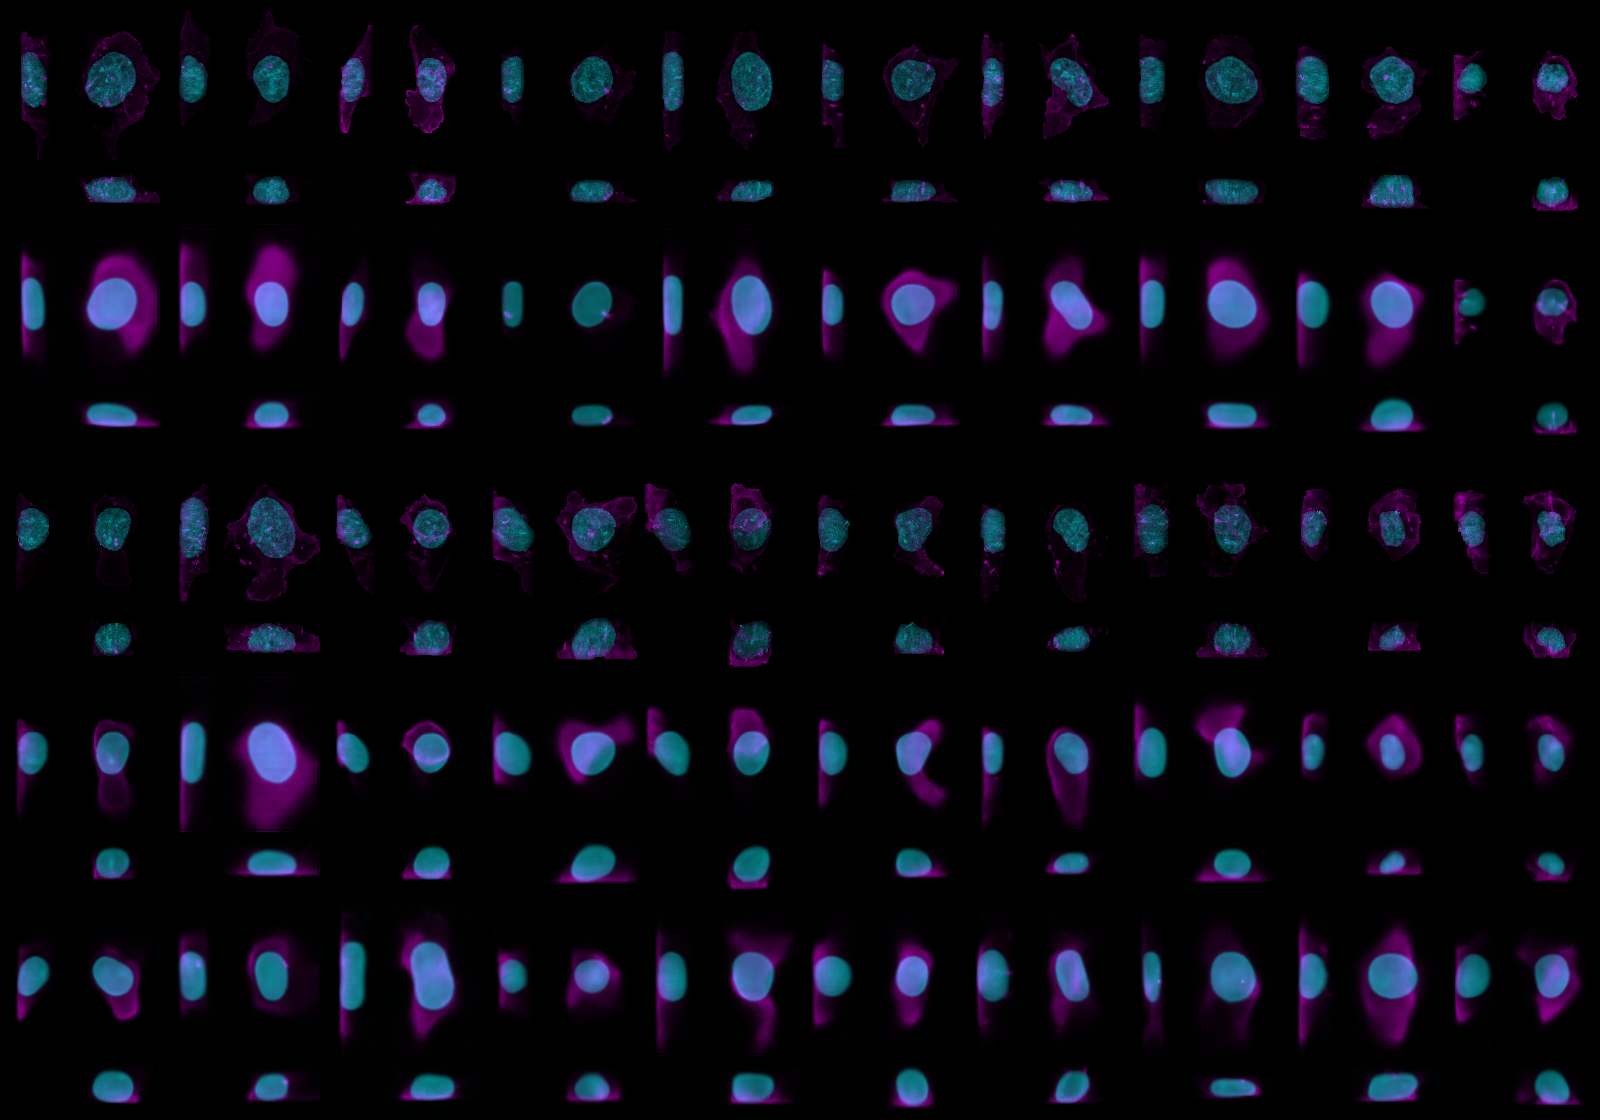

In [7]:
### from IPython.core.display import display
import imageio
import PIL.Image


import matplotlib.pyplot as plt
%matplotlib inline 

plt.style.use('default')

arrow_offset = 20

plt.figure()
for i, data in enumerate(data_list):
    if len(data['elbo']) == 0:
        continue
    
    if data['beta'] != 1:
        continue
    
    p = plt.plot(data['iteration'], data['elbo'], label=data['label'])
    ind = data['best_ind']

#     ind = best_ind[i]
    plt.scatter(data['iteration'][ind], data['elbo'][ind]+arrow_offset, s = 100, marker=r'$\downarrow$', color = p[0].get_color())
    
    plt.text(data['iteration'][ind], data['elbo'][ind]+arrow_offset, label[11::])
    
    
ylim = list(plt.ylim())
ylim[1] = -100
ylim[0] = -1000
plt.ylim(ylim)
plt.ylabel(r'$E_{(q|z)}[log P(X|z)] - D[Q(z|X)||P(z)]$')
# plt.ylabel(r'$E_{(q|z)}[log P(X|z)] - \beta D[Q(z|X)||P(z)]$')
plt.xlabel(r'epoch') 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()


rate = list()
distortion = list()
labels = list()
for i, data in enumerate(data_list):        
    ind = int(data['best_ind'])
    
    if ind == -1:
        continue
    
    labels.append(data['label'])
    rate.append(data['klds'][ind])
    distortion.append(data['recons'][ind])
    

plt.figure()
for d, r, l in zip(distortion, rate, labels):
    plt.scatter(r, d, label = l)
    
#     if l[11::] == "10:23:11":
    plt.text(r,d,l[11::])


xlim = list(plt.xlim())
ylim = list(plt.ylim())

xlim[0] = 0
ylim[0] = 0

# lim_max = np.max(np.hstack([xlim, ylim]))

xlim[1] = 750
# ylim[1] = lim_max

plt.xlim(xlim)

best_elbo = np.array([d['best_elbo'] for d in data_list])

plt.plot([0, np.min(-best_elbo)], [np.min(-best_elbo), 0], '--', c='gray')

plt.xlabel('rate (KLD)')
plt.ylabel('distortion (MSE)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()    

#display the example images

for i, data in enumerate(data_list):
    if len(data['elbo']) == 0:
        continue
    
    epoch_num = data['epoch'][data['best_ind']]
    
    im_out_path = '{}/ref_model/progress_{}.png'.format(data['model_dir'], int(epoch_num))  # CC
    
    print(data['model_dir'])
    
    
    im_progress = imageio.imread(im_out_path)  # CC
    display(PIL.Image.fromarray(im_progress))  # CC

In [8]:

best_model = 'asdfasdfasdf'  # CC

for i, data in enumerate(data_list):
    #if data['model_dir'] == "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae/2019-07-19-09:27:15/":  # CC
    if data['model_dir'] == "/allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae/2019-07-19-09:27:15/":  # CC
        best_model = i
        break

best_model = np.argmax(best_elbo)

for data in data_list:
# data = data_list[best_model]


    ind = int(data['best_ind'])  
    save_dir = data['model_dir']

    print("model_dir = '{}'".format(data['model_dir']))
    print("parent_dir = '{}'".format(parent_dir))
    print("suffix = '{}'".format(data['suffix'][ind]))


model_dir = '/allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04'
parent_dir = '/allen/aics/modeling/ic_data/results/integrated_cell/'
suffix = '_78372'
model_dir = '/allen/aics/modeling/ic_data/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:23:27'
parent_dir = '/allen/aics/modeling/ic_data/results/integrated_cell/'
suffix = '_93300'
